In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /Users/giovanni-
[nltk_data]     lunetta/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
df = pd.read_csv('/Users/giovanni-lunetta/uconn_masters/s2/epsy_5643/final_proposal/archive/full_merge_with_proper_columns.csv')

In [21]:
df.sample(5)

,text,upvote,sport,phase,category
8090,Who took the under for time on the national an...,8.0,Football,1,N
80010,There is no justice in the world,-2.0,Soccer,3,N
47808,Roma: That comeback against a Spanish superclu...,453.0,Soccer,1,N
9514,If Cam is gonna talk the biggest fucking talk ...,108.0,Football,3,4U
35864,Tom trolled the fuck out of everyone!,20.0,Football,2,N


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92235 entries, 0 to 92234
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      92235 non-null  object 
 1   upvote    92235 non-null  float64
 2   sport     92235 non-null  object 
 3   phase     92235 non-null  int64  
 4   category  92235 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.5+ MB


In [23]:
df['category'].value_counts()

category
N     80960
2U     2156
3F     1985
2F     1490
1F     1296
4U     1294
3U     1252
4F     1129
1U      673
Name: count, dtype: int64

In [24]:
df.head()

,text,upvote,sport,phase,category
0,The over-under on ridiculous Harbaugh reaction...,225.0,Football,1,N
1,*Sigh* this will be a few people in 12 hours\n...,92.0,Football,1,N
2,Prediction: Browns win by 35 in a surprise ups...,374.0,Football,1,N
3,IMAGINE IF THE RAVENS WIN AND FLACCO HOSTS SAT...,250.0,Football,1,N
4,"If they show Peyton face during the game, I'll...",46.0,Football,1,N


In [25]:
df = df[df['category'] != 'N']

In [26]:
df['category'].value_counts()

category
2U    2156
3F    1985
2F    1490
1F    1296
4U    1294
3U    1252
4F    1129
1U     673
Name: count, dtype: int64

In [27]:
df.sample(5)

,text,upvote,sport,phase,category
33183,Jimmy Carrapathrow.,5.0,Football,3,3U
25335,I could not possibly care less about #whosthep...,3.0,Football,1,2F
31118,"When the Pats won the coin toss, I said someth...",2.0,Football,3,1F
76652,Why is your flair shaped like a circumcised di...,17.0,Soccer,3,2U
37604,If any y’all don’t see any obscurity in the pe...,18.0,Football,3,4F


In [28]:
df['post_id'] = df.index

In [29]:
df.sample(5)

,text,upvote,sport,phase,category,post_id
3443,No lights no game redo!!,6.0,Football,2,2F,3443
55142,Just hide in Osama's cave.,274.0,Soccer,3,3U,55142
57535,There goes any hope of a good Alli-Son vs Alis...,4.0,Soccer,1,3F,57535
54491,Modric is playing so damn well.,3.0,Soccer,1,3F,54491
76016,I disagree. \n\nThey played VERY well. They we...,6.0,Soccer,3,2U,76016


In [30]:
df['sport'].value_counts()

sport
Soccer      5781
Football    5494
Name: count, dtype: int64

In [31]:
df["sport"] = np.where(df.sport == "Football", 1, 0)
df.sport.value_counts()

sport
0    5781
1    5494
Name: count, dtype: int64

In [32]:
df.set_index('post_id', inplace=True)

In [33]:
df.sample(10)

,text,upvote,sport,phase,category
post_id,,,,,
90218,WZAWZDB!!!!!!!!!!!,1.0,0,3,4U
49535,Ronaldo 7' brace after the half. I need someth...,2.0,0,1,3F
54168,Big boy Ramos got thrown down like a ragdoll b...,8.0,0,1,3U
69623,I'M SO FUCKING HAPPY BOYS\n\nGET IN YOU FUCKIN...,2.0,0,3,2U
70470,Credit to Chelsea as well\n\nTuchel has got th...,6.0,0,3,2F
40056,I’m so nervous bro,6.0,1,1,1U
75410,Courtois showed Liverpool fans who the best GK...,-3.0,0,3,2U
67229,Why doesn't Werner just be good again?,6.0,0,1,2U
47399,I'm very proud of our team. I don't even feel ...,3.0,0,3,1U


In [34]:
import nltk
import emoji
import re

STOPLIST = set(nltk.corpus.stopwords.words('english'))

def process_text(
    text: str,
    lower_case: bool = True,
    remove_punct: bool = True,
    keep_specific_punct: bool = True,
    remove_stopwords: bool = True,
    lemma: bool = True,
    emojis_to_words: bool = True,
    convert_urls: bool = True,
    string_or_list: str = "str",
):
    # Translate emojis to words if specified
    if emojis_to_words:
        text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Convert URLs to 'URL'
    if convert_urls:
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' URL ', text)
    
    # Preserve sequences of ! and ? before removing punctuations
    if keep_specific_punct:
        text = re.sub(r'([!?]+)', r' \1 ', text) # Separate punctuation sequences with spaces for tokenization
    
    tokens = nltk.word_tokenize(text)

    if lower_case:
        tokens = [token.lower() for token in tokens]

    # Remove punctuations except sequences of ! and ?
    if remove_punct:
        tokens = [token for token in tokens if token.isalpha() or re.match(r'^[!?]+$', token)]

    if remove_stopwords:
        tokens = [token for token in tokens if token not in STOPLIST]

    if lemma:
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens if not re.match(r'^[!?]+$', token)] + [token for token in tokens if re.match(r'^[!?]+$', token)]

    if string_or_list == "list":
        return tokens
    else:
        return " ".join(tokens)

In [35]:
df["tokens"] = df.text.apply(
    process_text, 
    lower_case = False,
    remove_punct = True,
    keep_specific_punct = True,
    remove_stopwords = False,
    lemma = True,
    emojis_to_words = True,
    convert_urls = True,
    string_or_list = "str")

In [40]:
df.sample(10)

,text,upvote,sport,phase,category,tokens
post_id,,,,,,
11633,Can you imagine being the Broncos D this *enti...,6.0,1,2,4U,Can you imagine being the Broncos D this entir...
87419,That goal sent chills down my spine,5.0,0,2,4U,That goal sent chill down my spine
26087,My girlfriend told me today that she might wan...,7.0,1,3,2F,My girlfriend told me today that she might wan...
70078,Very.,3.0,0,3,2U,Very
6102,Let's go crabtree,3.0,1,2,2F,Let go crabtree
81872,Kwey-drado,3.0,0,2,4F,
82784,Where are all the Allegri fans now? :),1.0,0,3,4F,Where are all the Allegri fan now ?
37656,I’m so glad I’m not high right now watching this,3.0,1,3,4F,I m so glad I m not high right now watching this
70358,It's happening,1.0,0,3,2U,It happening


In [41]:
docs_list = list(df.tokens)
# docs_list

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(min_df = 5)
X = vec.fit_transform(df.tokens)
matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out(), index=df.index)

In [43]:
matrix.sample(10)

,aaron,ability,able,about,above,abramovich,absolute,absolutely,abysmal,accept,...,yourself,youth,youtube,yup,zero,zidane,ziyech,zizou,zone,zoom
post_id,,,,,,,,,,,,,,,,,,,,,
28592,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42786,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6168,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50751,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83919,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73274,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65819,0.0,0.0,0.0,0.096396,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.351581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18976,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29678,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [45]:
def calculate_compound_sentiment(text):
    compound = sentiment_analyzer.polarity_scores(text)["compound"]
    return compound

In [46]:
df["compound_sentiment"] = df.tokens.apply(calculate_compound_sentiment)

In [47]:
df.sample(10)

,text,upvote,sport,phase,category,tokens,compound_sentiment
post_id,,,,,,,
17054,OH MY GOD OH MY GOD OH MY GOD OH MY GOD OH MY ...,25.0,1,2,2U,OH MY GOD OH MY GOD OH MY GOD OH MY GOD OH MY ...,0.9973
86521,Poor vini,9.0,0,2,4U,Poor vini,-0.4767
11834,"""I love great defensive games""\n\n(Great defen...",9.0,1,2,4U,I love great defensive game Great defensive ga...,0.8591
39826,All the cool kids liked knuckles,11.0,1,1,1U,All the cool kid liked knuckle,0.6249
66105,Yup,5.0,0,3,1F,Yup,0.0000
88405,WHAT A NIGHT I'M BUZZING,3.0,0,2,4U,WHAT A NIGHT I BUZZING,0.0000
740,Tucker doesn't miss the ridiculously easy ones.,1.0,1,1,2U,Tucker doe miss the ridiculously easy one,-0.0258
6971,I may or may not have drank WAY too much last ...,3.0,1,3,4U,I may or may not have drank WAY too much last ...,0.0000
74684,Courtois 💪💪💪,5.0,0,3,2U,Courtois,0.0000


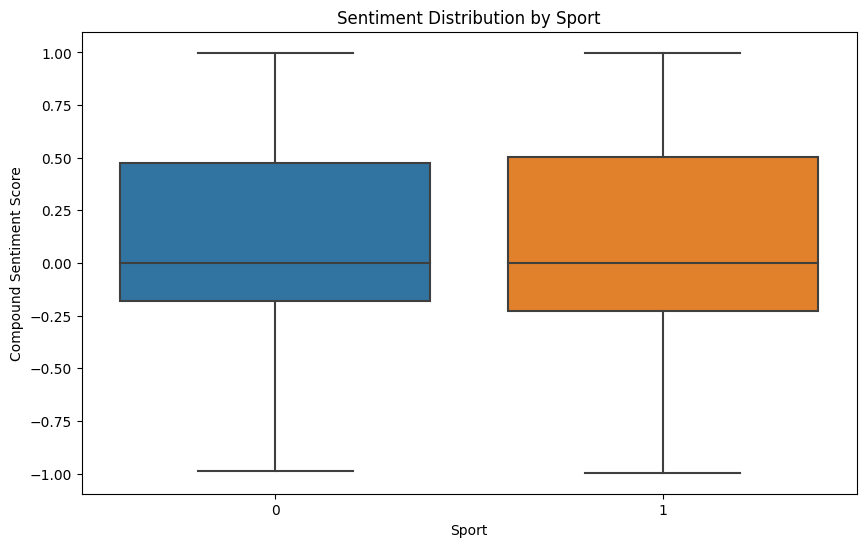

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sentiment Distribution by Sport
plt.figure(figsize=(10, 6))
sns.boxplot(x='sport', y='compound_sentiment', data=df)
plt.title('Sentiment Distribution by Sport')
plt.xlabel('Sport')
plt.ylabel('Compound Sentiment Score')
plt.show()

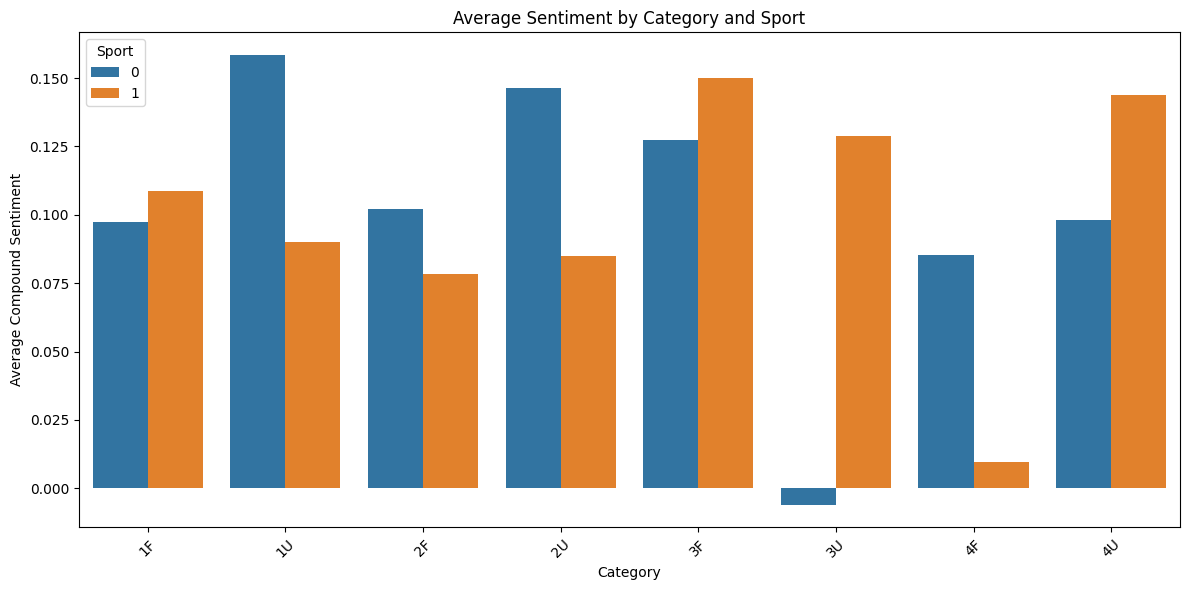

In [49]:
# Calculate the average compound_sentiment for each category and sport
avg_sentiment = df.groupby(['category', 'sport'])['compound_sentiment'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='compound_sentiment', hue='sport', data=avg_sentiment)

plt.title('Average Sentiment by Category and Sport')
plt.xlabel('Category')
plt.ylabel('Average Compound Sentiment')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.legend(title='Sport')
plt.tight_layout()  # Adjusts plot parameters to give some padding
plt.show()

| Scenario                                               | Sentiment Comparison Across Sports                             |
|--------------------------------------------------------|---------------------------------------------------------------|
| 1F: Favored team winning a close match (Favored team subreddit) | Relatively the same across sports                             |
| 1U: Favored team winning a close match (Underdog team subreddit) | Underdog soccer fans' comments more positive than football    |
| 2F: Favored team winning a one-sided match (Favored team subreddit) | Relatively the same across sports                             |
| 2U: Favored team winning a one-sided match (Underdog team subreddit) | Underdog soccer fans' comments more positive than football    |
| 3F: Underdog team winning a close match (Favored team subreddit) | Relatively the same across sports                             |
| 3U: Underdog team winning a close match (Underdog team subreddit) | Underdog soccer fans' comments more negative than football    |
| 4F: Underdog team winning a one-sided match (Favored team subreddit) | Favored soccer fans' comments more positive than football     |
| 4U: Underdog team winning a one-sided match (Underdog team subreddit) | Underdog football fans' comments more positive than soccer    |


Main Takeaways:

Sentiment tends to be consistent across sports when the favored team is winning, regardless of the match being close or one-sided.
Differences in sentiment are more pronounced in underdog scenarios, with soccer fans displaying more positivity when their team is losing and more negativity when winning closely.

The distinction in fan sentiment becomes particularly evident in one-sided matches, emphasizing the influence of match context on fan reactions across sports.

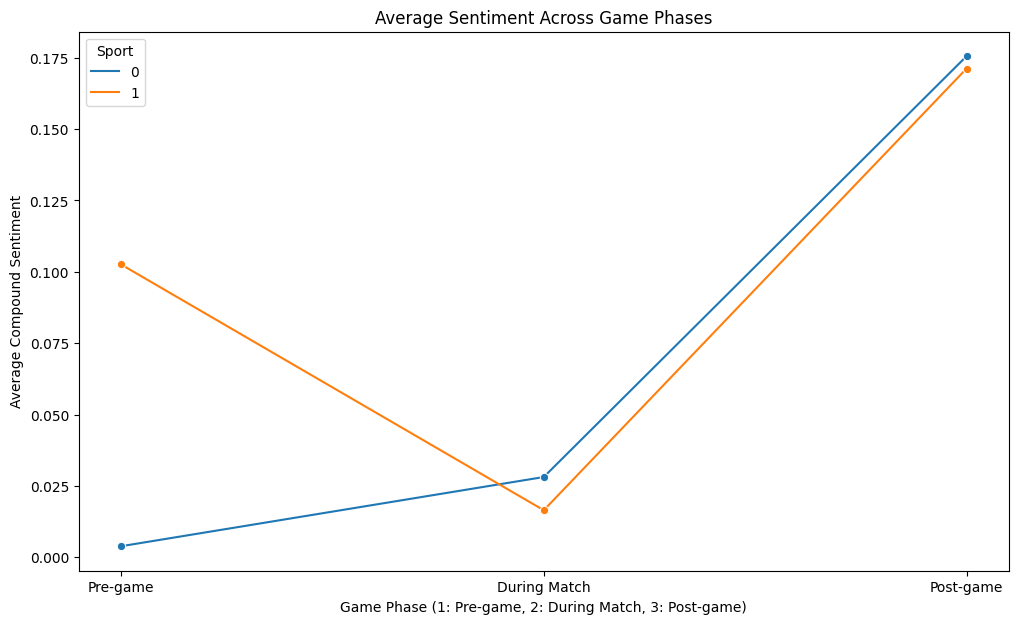

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, calculate the average sentiment for each phase and sport
avg_sentiment = df.groupby(['phase', 'sport'])['compound_sentiment'].mean().reset_index()

# Convert 'phase' to a categorical type for proper ordering in the plot
avg_sentiment['phase'] = pd.Categorical(avg_sentiment['phase'], categories=[1, 2, 3], ordered=True)

# Now plot
plt.figure(figsize=(12, 7))
sns.lineplot(x='phase', y='compound_sentiment', hue='sport', data=avg_sentiment, marker='o')
plt.title('Average Sentiment Across Game Phases')
plt.xlabel('Game Phase (1: Pre-game, 2: During Match, 3: Post-game)')
plt.ylabel('Average Compound Sentiment')
plt.xticks(ticks=[1, 2, 3], labels=['Pre-game', 'During Match', 'Post-game'])
plt.legend(title='Sport')
plt.show()

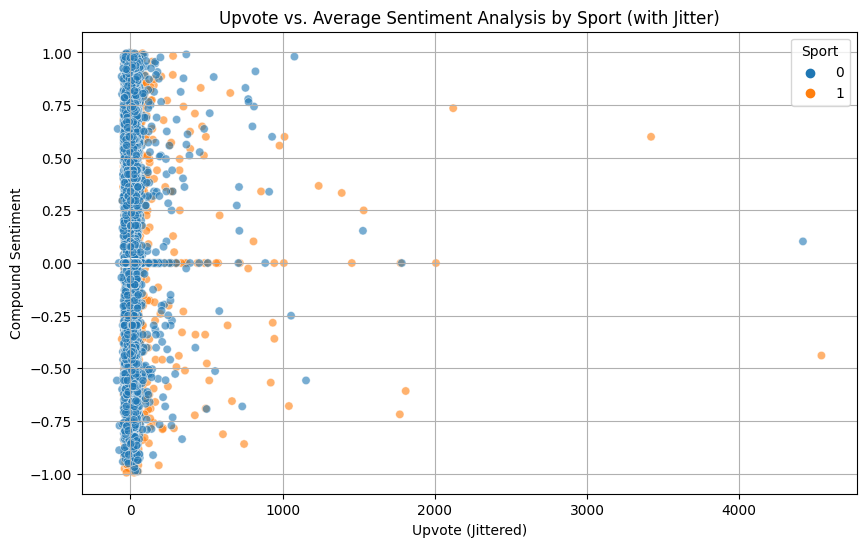

In [51]:
df['upvote_jittered'] = df['upvote'] + (np.random.rand(len(df)) - 0.5) * 0.02 * df['upvote'].max()

# Now creating the scatter plot with jittered 'upvote'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='upvote_jittered', y='compound_sentiment', hue='sport', alpha=0.6)

plt.title('Upvote vs. Average Sentiment Analysis by Sport (with Jitter)')
plt.xlabel('Upvote (Jittered)')
plt.ylabel('Compound Sentiment')
plt.legend(title='Sport')
plt.grid(True)
plt.show()

In [52]:
df = pd.get_dummies(df, columns=['category'], drop_first=True)

In [53]:
X = df.drop(columns = ["text", "tokens", "sport"])
y = df["sport"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2896849, stratify = y)

X_train.shape, X_test.shape

((9020, 11), (2255, 11))

In [54]:
param_grid = {
    'n_estimators': [50, 150, 200, 300],  # Number of boosting stages
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'max_depth': [3, 5, 10]  # Maximum depth of the individual trees
}
f1_scorer = make_scorer(f1_score)
boosted_forest = GradientBoostingClassifier()

grid_search = GridSearchCV(boosted_forest, param_grid, cv=StratifiedKFold(n_splits=5), scoring = f1_scorer)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [55]:
bf_model = GradientBoostingClassifier(learning_rate = best_params["learning_rate"], max_depth = best_params["max_depth"], n_estimators = best_params["n_estimators"])
bf_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=150)

In [56]:
test_predictions = bf_model.predict(X_test)

accuracy = accuracy_score(y_true = y_test, y_pred = test_predictions)
precision = precision_score(y_true = y_test, y_pred = test_predictions)
recall = recall_score(y_true = y_test, y_pred = test_predictions)
f1 = f1_score(y_true = y_test, y_pred = test_predictions)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.7494456762749445
Precision: 0.7730061349693251
Recall: 0.6878980891719745
F1: 0.7279730380356283


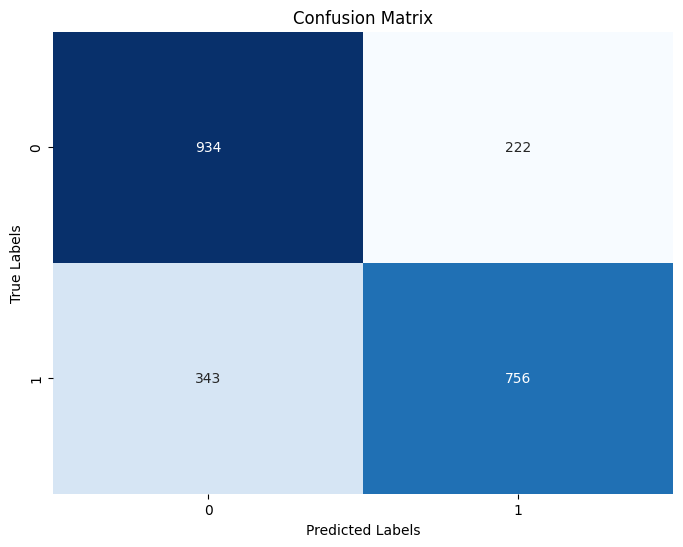

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [58]:
feature_importance = pd.DataFrame(bf_model.feature_importances_, index = X_train.columns, columns = ['importance'])

In [59]:
feature_importance

,importance
upvote,0.222747
phase,0.307492
compound_sentiment,0.085347
upvote_jittered,0.093929
category_1U,0.018668
category_2F,0.061625
category_2U,0.120701
category_3F,0.023903
category_3U,0.026137
category_4F,0.014539
